In [62]:
import sys 
from bfseg.data.fsdata import load_fsdata
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import tensorflow_datasets as tfds
from zipfile import ZipFile
import bfseg.models.fast_scnn
import bfseg.data.hive.office_rumlang_validation_labeled
import bfseg.data.hive.bfseg_validation_labeled
from bfseg.utils.utils import load_gdrive_file
from matplotlib import colors
#from bfseg.settings import TMPDIR
TMPDIR = "/home/matthias/data/rss_2021_data/tmp/"
MASKPATH = "/home/matthias/data/rss_2021_data/mask.png"

## Load important data

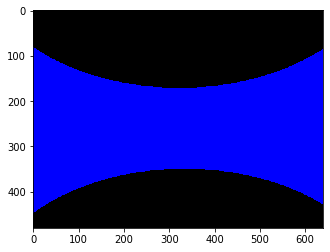

In [87]:
# Load mask
mask = plt.imread(MASKPATH)
ax = plt.subplot()
# foreground, background, unknown
cmap3 = colors.ListedColormap(['black', 'blue', 'gray'])
cmap2 = colors.ListedColormap(['black', 'blue'])
ax.imshow(mask, cmap=cmap2)
mask_filtered = np.nonzero(mask)
test = mask[mask_filtered]

In [4]:
# Test dataset:
val_ds_office_gt = tfds.load('office_rumlang_validation_labeled', split='OFFICE')

In [5]:
# NYU Depth dataset:
nyu_depth_ds = tfds.load("NyuDepthV2LabeledDepth", split="full[:1%]")

In [6]:
# Office 12 dataset:
val_ds_office_12 = tfds.load('MeshdistPseudolabelsDense', split='office12_dense20_dyn_cam2[:10%]')

In [41]:
# Office 3 dataset:
val_ds_office_3 = tfds.load('MeshdistPseudolabelsDense', split='office3_combined2050_dyn_cam2[:10%]')

## gt_segmentation_example

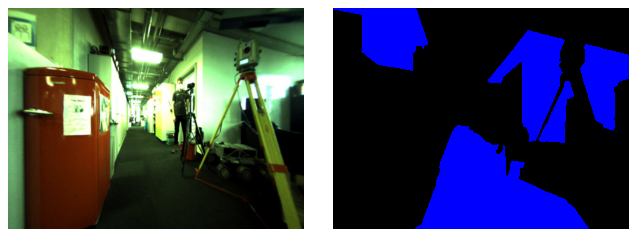

In [92]:
samples_iter = iter(val_ds_office_gt.take(10))
for i in range(3):
    entry1 = next(samples_iter)

figure0 = plt.figure(figsize=(10, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(1,2,1)
plt.imshow(entry1['image'])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(entry1['label'], cmap=cmap2)
plt.axis('off')

figure0.savefig("presentation_figures/gt_segmentation_example.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/gt_segmentation_example.png", bbox_inches='tight')


## dense_pseudolabels_example1 (rgb, sparse, dense, depth)

In [49]:
datapath = '/home/matthias/data/rss_2021_data/label_aggregator_dense/labels_lidar/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


(-0.5, 759.5, 399.5, -0.5)

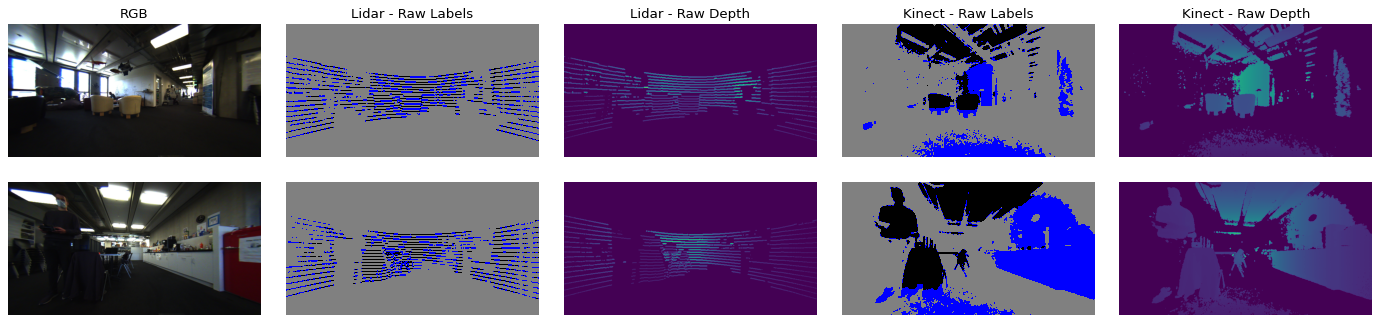

In [90]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(22, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,5,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,5,2)
unaggregated = np.where(tf.logical_and(entry1['unaggregatedlabels'] > 0, entry1['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry1['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated, cmap=cmap3)
ax1.set_title('Lidar - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,3)
ax1.imshow(entry1['sparsedepthlabels'], vmin=0, vmax=255)
ax1.set_title('Lidar - Raw Depth')
plt.axis('off')
ax1 = plt.subplot(2,5,4)
ax1.imshow(entry1['denselabels'], cmap=cmap3)
ax1.set_title('Kinect - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,5)
ax1.imshow(entry1['depthlabels'], vmin=0, vmax=255)
ax1.set_title('Kinect - Raw Depth')
plt.axis('off')

ax1 = plt.subplot(2,5,6)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,5,7)
unaggregated = np.where(tf.logical_and(entry2['unaggregatedlabels'] > 0, entry2['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry2['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated, cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,5,8)
ax1.imshow(entry2['sparsedepthlabels'], vmin=0, vmax=255)
plt.axis('off')
ax1 = plt.subplot(2,5,9)
ax1.imshow(entry2['denselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,5,10)
ax1.imshow(entry2['depthlabels'], vmin=0, vmax=255)
plt.axis('off')

## dense_pseudolabels_example2 (rgb, sparse, dense, combined)

In [85]:
datapath = '/home/matthias/data/rss_2021_data/label_aggregator_dense/labels_lidar/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


(-0.5, 759.5, 399.5, -0.5)

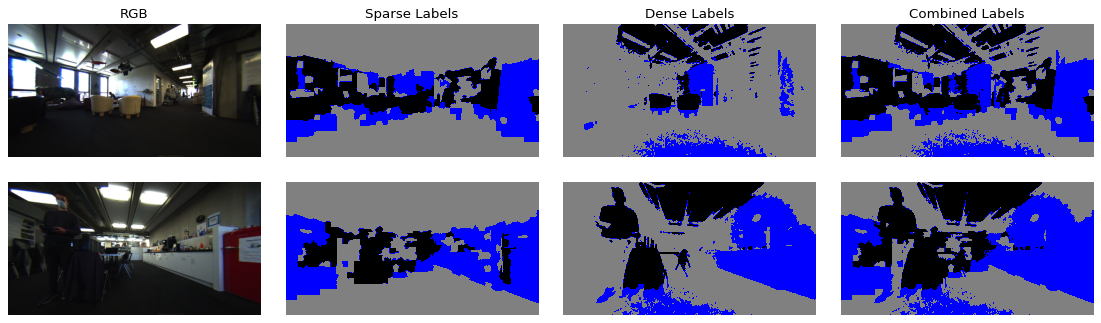

In [89]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(17.5, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,4,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,4,2)
ax1.imshow(entry1['sparselabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Sparse Labels')
ax1 = plt.subplot(2,4,3)
ax1.imshow(entry1['denselabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Dense Labels')
ax1 = plt.subplot(2,4,4)
ax1.imshow(entry1['combinedlabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Combined Labels')

ax1 = plt.subplot(2,4,5)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,4,6)
ax1.imshow(entry2['sparselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,4,7)
ax1.imshow(entry2['denselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,4,8)
ax1.imshow(entry2['combinedlabels'], cmap=cmap3)
plt.axis('off')

## visual_results_fastscnn1 (rgb, pretraining, sparse, dense, combined)

In [15]:
pretraining_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_initial.h5')
sparse_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_10.h5')
dense_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_dense20_dyn_cam2_finetuning_1/model_epoch_5.h5')
combined_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_combined2050_dyn_cam2_finetuning_1/model_epoch_6.h5')
combined_model_overfit = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_combined2050_dyn_cam2_finetuning_1full/model_epoch_50.h5')

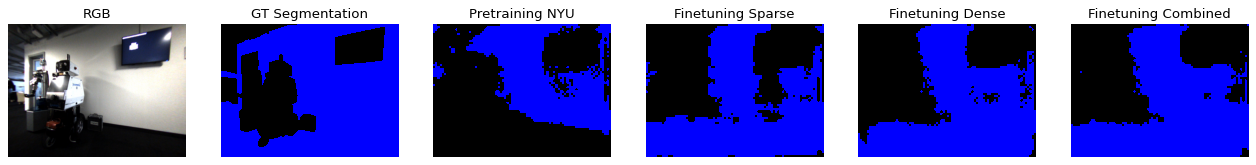

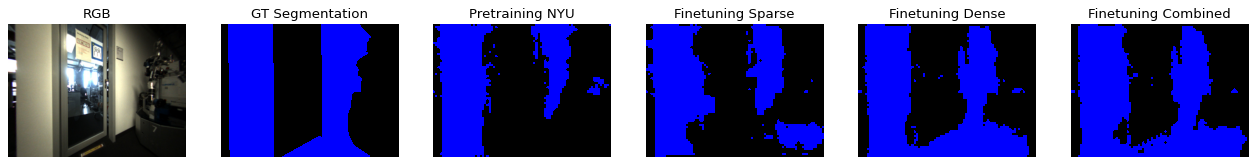

In [83]:
## On Office GT: best: 24, (8, 15, 17)

samples_iter1 = iter(val_ds_office_gt)
samples_iter2 = iter(val_ds_office_gt)
entries = list()
"""
index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(17):
    entry1 = next(samples_iter1)
for i in range(24):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)

    
for entry in entries:
    figure = plt.figure(figsize=(20, 5), dpi=80)
    # RGB
    ax1 = plt.subplot(1,6,1)
    ax1.imshow(entry['image'])
    ax1.set_title('RGB')
    plt.axis('off')
    # GT Segmentation
    ax1 = plt.subplot(1,6,2)
    plt.axis('off')
    ax1.imshow(entry['label'], cmap=cmap2)
    ax1.set_title('GT Segmentation')
    # Pretrained Segmentation
    ax1 = plt.subplot(1,6,3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = pretraining_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Pretraining NYU')
    # Sparse Segmentation
    ax1 = plt.subplot(1,6,4)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = sparse_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Sparse')
    # Dense Segmentation
    ax1 = plt.subplot(1,6,5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = dense_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Dense')
    # Combined Segmentation
    ax1 = plt.subplot(1,6,6)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = combined_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Combined')

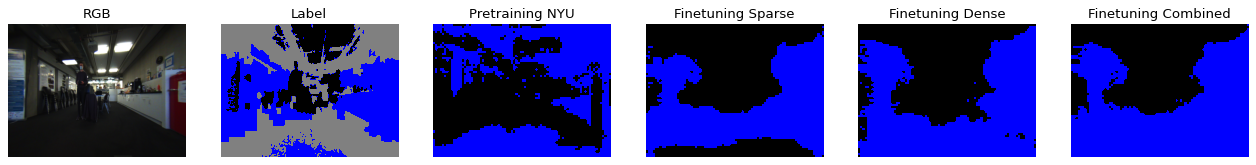

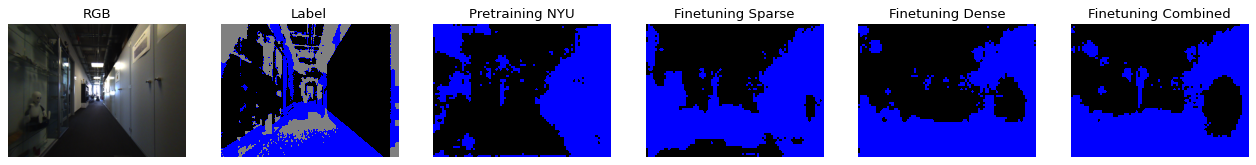

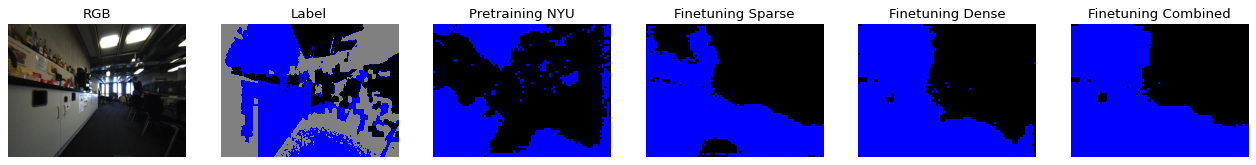

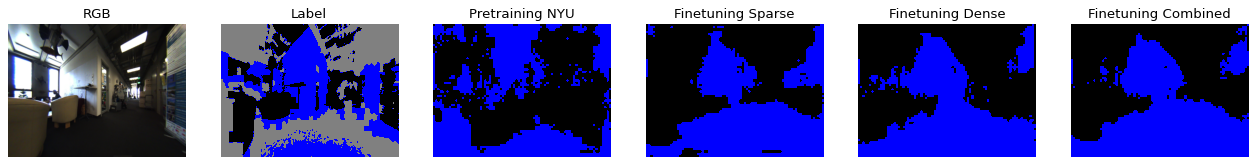

In [88]:
def preprocess_bagfile(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image and label.
    image = tf.image.resize(image, (480, 640),
                          method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, (480, 640),
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Mask out unknown pixels.
    mask = tf.squeeze(tf.not_equal(label, 2))
    #label = tf.cast(label == 1, tf.uint8)
    image = tf.cast(image, tf.float32)
    return image, label, mask 

## On Office 12

samples_iter1 = iter(val_ds_office_3)
samples_iter2 = iter(val_ds_office_3)
entries = list()

index = 10
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(4):
    entry1 = next(samples_iter1)
for i in range(5):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)
"""

    
for entry in entries:
    image, label, mask = preprocess_bagfile(entry['image'], entry['label'])
    
    figure = plt.figure(figsize=(20, 5), dpi=80)
    # RGB
    ax1 = plt.subplot(1,6,1)
    ax1.imshow(image)
    ax1.set_title('RGB')
    plt.axis('off')
    # GT Segmentation
    ax1 = plt.subplot(1,6,2)
    plt.axis('off')
    ax1.imshow(label, cmap=cmap3)
    ax1.set_title('Label')
    # Pretrained Segmentation
    ax1 = plt.subplot(1,6,3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = pretraining_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Pretraining NYU')
    # Sparse Segmentation
    ax1 = plt.subplot(1,6,4)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = sparse_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Sparse')
    # Dense Segmentation
    ax1 = plt.subplot(1,6,5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = dense_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Dense')
    # Combined Segmentation
    ax1 = plt.subplot(1,6,6)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = combined_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    ax1.set_title('Finetuning Combined')

## visual_results_fastscnn+depth_nyu1 (rgb, gt_seg, pred_seg, gt_depth, pred_depth)

In [51]:
from scipy import stats
def ignorant_depth_loss(depth_label, y_pred_depth, maxDepthVal=1000.0 / 10.0): 
    """
    wrapper to mask all "NaN" values in depth
    """
    y_pred_depth_ignorant = tf.where(tf.math.is_nan(depth_label),
                                     tf.zeros_like(depth_label), y_pred_depth)
    depth_label = tf.where(tf.math.is_nan(depth_label),
                           tf.zeros_like(depth_label), depth_label)
    #print("Ignorant depth loss: ")
    #print("depth_label: {}".format(depth_label))
    #print("y_pred_depth_ignorant: {}".format(y_pred_depth_ignorant))

    return depth_loss_function(depth_label, y_pred_depth_ignorant, maxDepthVal=maxDepthVal)


def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0 / 10.0): 
    """ Loss Function from DenseDepth paper.
      Code taken from here https://github.com/ialhashim/DenseDepth/blob/master/loss.py
    """

    # Point-wise depth
    l_depth = tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true),
                                    axis=-1)
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = tf.keras.backend.mean(tf.keras.backend.abs(dy_pred - dy_true) +
                                    tf.keras.backend.abs(dx_pred - dx_true),
                                    axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = tf.keras.backend.clip(
        (1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * tf.keras.backend.mean(l_edges)) + (
        w3 * tf.keras.backend.mean(l_depth))

def tf_boxcox(input):
    y = tf.numpy_function(stats.boxcox, [input], (tf.float32, tf.float64))
    return y 

def preprocess_boxcox_standardize(depth_label_orig):
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    #depth_norm_2 = 10 / depth_norm_2
    
    # boxcox in 1D
    old_shape = depth_norm_2.shape
    depth_flattened = tf.reshape(depth_norm_2, [-1])
    depth_flattened_trans, _  = tf_boxcox(depth_flattened)
    depth_restored = tf.reshape(depth_flattened_trans, old_shape)
    
    # standardize
    depth_standardized = tf.image.per_image_standardization(depth_restored)
    return depth_standardized

tf.Tensor([0.18442938], shape=(1,), dtype=float32)
tf.Tensor([0.14951706], shape=(1,), dtype=float32)


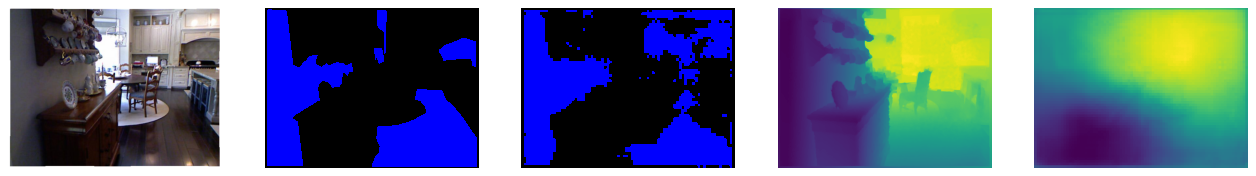

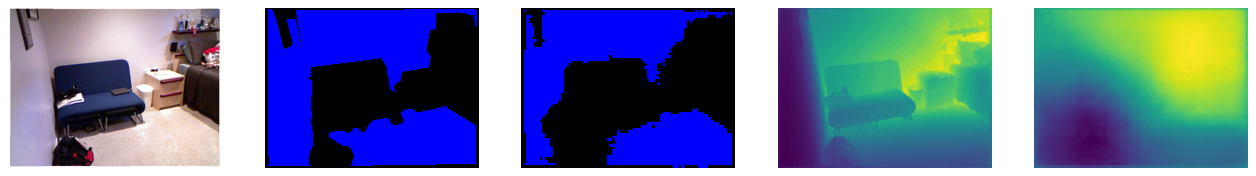

In [82]:
# BoxCox + standardize
samples_iter1 = iter(nyu_depth_ds)
samples_iter2 = iter(nyu_depth_ds)
entries = list()
"""
index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(1):
    entry1 = next(samples_iter1)
for i in range(2):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)

 
model0 = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_9/model_epoch_20.h5', custom_objects={'tf': tf})
for entry in entries:
    figure = plt.figure(figsize=(20, 5), dpi=80)
    # RGB
    ax1 = plt.subplot(1,5,1)
    plt.axis('off')
    ax1.imshow(entry['image'])
    # GT Semseg
    ax1 = plt.subplot(1,5,2)
    plt.axis('off')
    ax1.imshow(entry['label']['seg'], cmap=cmap2)
    # Pred Semseg
    ax1 = plt.subplot(1,5,3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    # Depth label
    ax1 = plt.subplot(1,5,4)
    plt.axis('off')
    depth_label_orig = entry['label']['distance']
    depth_label_preproc = preprocess_boxcox_standardize(depth_label_orig)
    plot1 = ax1.imshow(depth_label_preproc)
    # plt.colorbar(plot1,ax=ax1)
    label_depth = tf.expand_dims(depth_label_preproc,0)
    
    # Depth predictions
    ax1 = plt.subplot(1,5,5)
    plt.axis('off')
    depth = b[2]
    plot1 = ax1.imshow(depth[0,:,:])
    # plt.colorbar(plot1,ax=ax1)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    
    print(ignorant_depth_loss(label_depth, pred_depth))

## visual_results_fastscnn+depth_1 (rbg, gt_seg, pred_seg, pred_depth)